# El problema de la rana

El *problema de la rana* es un ejercicio de probabilidad que dice lo siguiente: supongamos que hay una rana que siempre salta la misma distancia, y cada vez que salta lo hace en una dirección aleatoria, entonces ¿cuál es la distribución de probabilidad de la distancia al origen después de $n$ saltos?

Asumimos que la rana salta en un plano, y que "dirección aleatoria" quiere decir que la variable aleatoria que define la dirección de salto sigue una distribución uniforme, entonces la variable aleatoria que define la distancia tras $n$ saltos viene dada por

$$
Y_n=\left|\sum_{k=1}^n e^{i X_k}\right|=\sqrt{n+2\sum_{1\le j< k\le n}\cos (X_j-X_k)}
$$

donde cada $X_k$ es independiente de la otra y todas tienen una distribución uniforme en $[0,2\pi]$. Dos formas de atacar el problema: a través de una aproximación analítica o con una simulación con números pseudo-aleatorios.

## Aproximación analítica

A partir de $n\ge 3$ se hace complicado calcular explícitamente la función de densidad de $Y_n$, así que en principio nos tendríamos que contentar con una aproximación teórica. Para esto podemos utilizar el teorema central del límite para vectores aleatorios, ya que también podemos representar cada salto aleatorio por el vector $V_k:=(cos(X_j),sin(X_j))$, entonces sabemos que si la varianza de cada $V_k$ es finita

$$
\frac1{\sqrt n}\left(\sum_{k=1}^n V_k-\mu\right)\overset{\text{distribución}}{\longrightarrow}N,\quad n\to\infty
$$

donde $N$ es una variable aleatoria con distribución binormal de media $\mu$ y covarianza igual a las de los $V_k$, siendo $\mu$ la media de los $V_k$. A partir de ahí se puede mostrar que la distribución de $Y_n/\sqrt n$ se aproxima a $2xe^{−x^2}$ conforme $n$ tiende a infinito, y por tanto

$$
f_{Y_n}(x)\approx \frac{2x}{n}e^{-\frac{x^2}n}
$$

para $n$ suficientemente grande.

## Simulación con números pseudo-aleatorios

Haremos una simulación con el lenguaje de programación Julia y algunas librerías. El siguiente código simula la distancia recorrida tras $n$ saltos aleatorios

In [1]:
function rd(n::Int)
    p = 1.0 # el primer salto
    for j in 2:n
        p += exp(2pi * im * rand())
    end
    return abs(p)
end;

A partir de la función anterior generamos una matriz que contenga un número elevado de experimentos aleatorios, lo hacemos con la siguien función

In [2]:
function sim(n::Int, m::Int = 22)
    datos = zeros(2^m) # matriz vacía a rellenar
    for i in 1:2^m
        datos[i] = rd(n)
    end
    return datos
end;

La función anterior se ejecuta como `sim(n)` o como `sim(n,m)`, donde `n` representa el número de saltos y `m` es un parámetro opcional que define el número de experimentos aleatorios a realizar.

## Graficación

El siguiente código define una función que grafica las funciones de densidad o las distribuciones de probabilidad, y permite comparar la simulación con números pesudo-aleatorios y la aproximación analítica descrita anteriormente

In [3]:
using KernelDensity, Plots
function p1(n::Int, m::Int= 22; cdf::Int = -1, c::Symbol = :auto)
    r = 0:n/100:n
    k = kde(sim(n,m))
    cdf <= 0 && begin
        p = plot!(r, pdf.(Ref(k), r),
            color = c,
            xlabel = "Distancia",
            label = "PDF simulada de $n saltos")
        f(y) = 2y*exp(-y^2/n)/n
        p = plot!(f, 0, n, l = :dash, w = 3, color = c,
            label = "PDF aproximada de $n saltos")
        end
    cdf >= 0 && begin
        x = pdf.(Ref(k),r)
        cdfx = cumsum(x)/sum(x)
        p = plot!(r, cdfx, color = c,
            label = "CDF simulada de $n saltos")
        g(y) = 1- exp(-y^2/n)
        p = plot!(g, 0, n, l = :dash, w = 3, color = c,
            label = "CDF aproximada de $n saltos",
            xlabel = "Distancia",
            ylabel = "Probabilidad")
        end
return p
end;

Cada vez que llamamos a la función `p1` añade una gráfica más sobre el mismo lienzo, los parámetros `m` y `c` son opcionales, el primero (al igual que antes) controla la cantidad de experimentos sobre la que hacer las estimaciones, y el segundo [la paleta de colores a usar](https://docs.juliaplots.org/latest/colors/). Un ejemplo

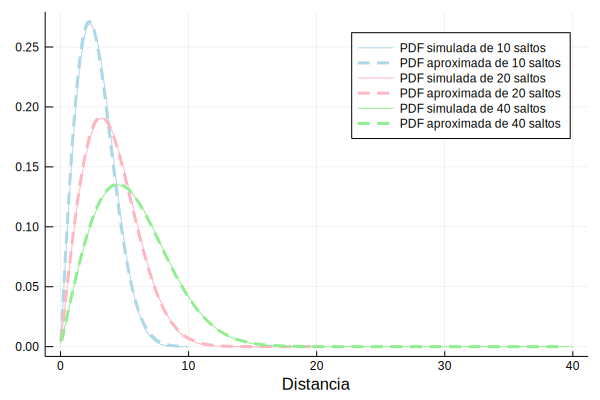

In [4]:
p1(10, c=:blues); p1(20, c=:reds); p1(40, c=:greens)

Y con la misma función podemos dibujar las distribuciones de probabilidad, añadiendo la opción `cdf = 1`

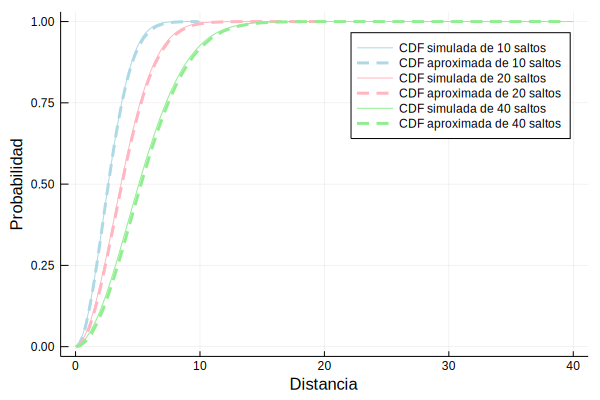

In [5]:
plot(); # Reseteamos el lienzo para empezar a graficar en uno nuevo
p1(10, c=:blues, cdf = 1); p1(20, c=:reds, cdf = 1); p1(40, c=:greens, cdf = 1)